In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os

2025-07-16 20:31:41.848389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752697902.207639      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752697902.312534      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
train_image_paths = glob.glob('/kaggle/input/deepglobe-road-extraction-dataset/train/*_sat.jpg')
train_mask_paths = glob.glob('/kaggle/input/deepglobe-road-extraction-dataset/train/*_mask.png')
test_image_paths = glob.glob('/kaggle/input/deepglobe-road-extraction-dataset/test/*_sat.jpg')
val_image_paths = glob.glob('/kaggle/input/deepglobe-road-extraction-dataset/valid/*_sat.jpg')

In [ ]:
print(len(train_image_paths))
print(len(train_mask_paths))
print(len(test_image_paths))
print(len(val_image_paths))

6226
6226
1101
1243


In [ ]:
def get_image_mask_pairs(image_paths, mask_dir, image_suffix='_sat.jpg', mask_suffix='_mask.png'):
    pairs = []
    for img_path in image_paths:
        basename = os.path.basename(img_path).replace(image_suffix, '')
        mask_path = os.path.join(mask_dir, basename + mask_suffix)
        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path))
    return pairs

train_pairs = get_image_mask_pairs(train_image_paths, '/kaggle/input/deepglobe-road-extraction-dataset/train')

In [ ]:
train_images = [img for img, _ in train_pairs]
train_masks = [mask for _, mask in train_pairs]

In [ ]:
preprocess_images = []
for img in train_images:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = image / 255.0
    preprocess_images.append(image)

In [ ]:
preprocess_masks = []
for mask in train_masks:
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    preprocess_masks.append(mask)

In [ ]:
X_train = np.array(preprocess_images, dtype=np.float32)

preprocess_masks = np.array(preprocess_masks, dtype=np.float32)
preprocess_masks = np.expand_dims(preprocess_masks, axis=-1)
preprocess_masks = (preprocess_masks > 0.5).astype(np.int32)

y_train = preprocess_masks

In [ ]:
print(X_train.shape)
print(y_train.shape)

(6226, 256, 256, 3)
(6226, 256, 256, 1)


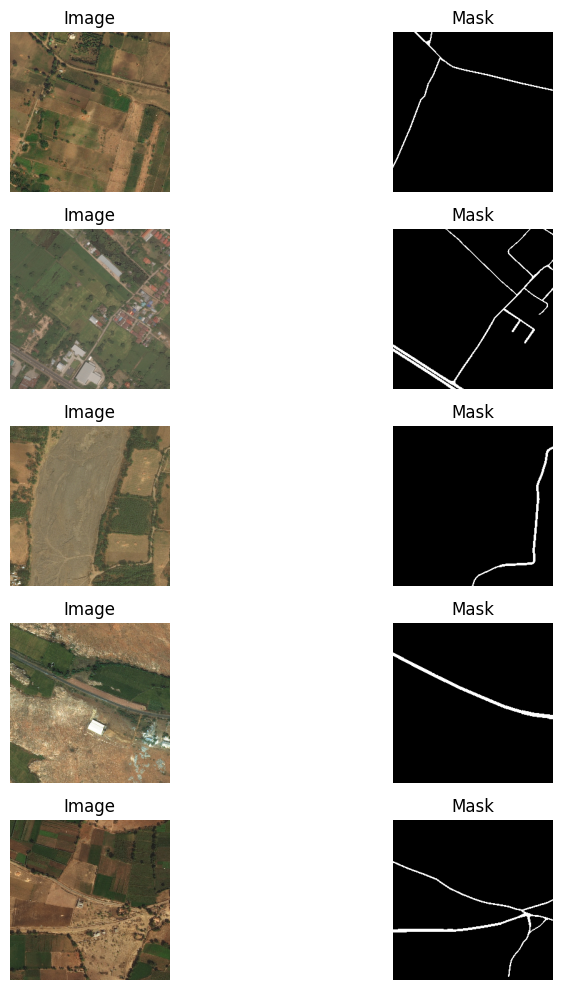

In [ ]:
num_samples = 5

plt.figure(figsize=(10, 10))

for i in range(num_samples):
    plt.subplot(num_samples, 2, i * 2 + 1)
    plt.imshow(X_train[i])
    plt.title("Image")
    plt.axis("off")

    plt.subplot(num_samples, 2, i * 2 + 2)
    plt.imshow(y_train[i], cmap='gray')
    plt.title("Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
inputs = Input(shape=(256, 256, 3))

c1 = Conv2D(64, (3, 3), padding='same')(inputs)
c1 = BatchNormalization()(c1)
c1 = LeakyReLU(alpha=0.1)(c1)
c1 = Conv2D(64, (3, 3), padding='same')(c1)
c1 = BatchNormalization()(c1)
c1 = LeakyReLU(alpha=0.1)(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
p4 = MaxPooling2D((2, 2))(c4)

b = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
b = Conv2D(1024, (3, 3), activation='relu', padding='same')(b)

u1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(b)
u1 = concatenate([u1, c4])
c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

u2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u2 = concatenate([u2, c3])
c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u3 = concatenate([u3, c2])
c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u4 = concatenate([u4, c1])
c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c8)

model = Model(inputs=inputs, outputs=outputs)

early_stopping = EarlyStopping(monitor='val_dice_coefficient', mode='max', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

I0000 00:00:1752698191.518893      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752698191.519700      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 31,032,257 (118.38 MB)

 Trainable params: 31,032,001 (118.38 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=dice_loss, metrics=[dice_coefficient, iou_metric])

In [ ]:
history = model.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


I0000 00:00:1752698217.285549     106 service.cc:148] XLA service 0x7f748c003720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752698217.288326     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752698217.288352     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752698218.521794     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752698281.878959     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - dice_coefficient: 0.1835 - iou_metric: 0.1023 - loss: 0.8165

E0000 00:00:1752698574.889089     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752698575.117422     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752698580.428392     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752698580.737560     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752698587.120076     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coefficient: 0.1837 - iou_metric: 0.1025 - loss: 0.8163   

E0000 00:00:1752698670.003237     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752698670.242274     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


312/312 ━━━━━━━━━━━━━━━━━━━━ 469s 1s/step - dice_coefficient: 0.1839 - iou_metric: 0.1026 - loss: 0.8161 - val_dice_coefficient: 0.0114 - val_iou_metric: 0.0058 - val_loss: 0.9886 - learning_rate: 1.0000e-04
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - dice_coefficient: 0.4176 - iou_metric: 0.2654 - loss: 0.5824 - val_dice_coefficient: 0.4446 - val_iou_metric: 0.2875 - val_loss: 0.5554 - learning_rate: 1.0000e-04
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - dice_coefficient: 0.5271 - iou_metric: 0.3594 - loss: 0.4729 - val_dice_coefficient: 0.5673 - val_iou_metric: 0.3970 - val_loss: 0.4327 - learning_rate: 1.0000e-04
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - dice_coefficient: 0.5860 - iou_metric: 0.4157 - loss: 0.4140 - val_dice_coefficient: 0.5865 - val_iou_metric: 0.4160 - val_loss: 0.4135 - learning_rate: 1.0000e-04
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - dice_coefficient: 0.6187 - iou_metric: 0.4491 - loss: 0.3813 - val_dice_coeffici

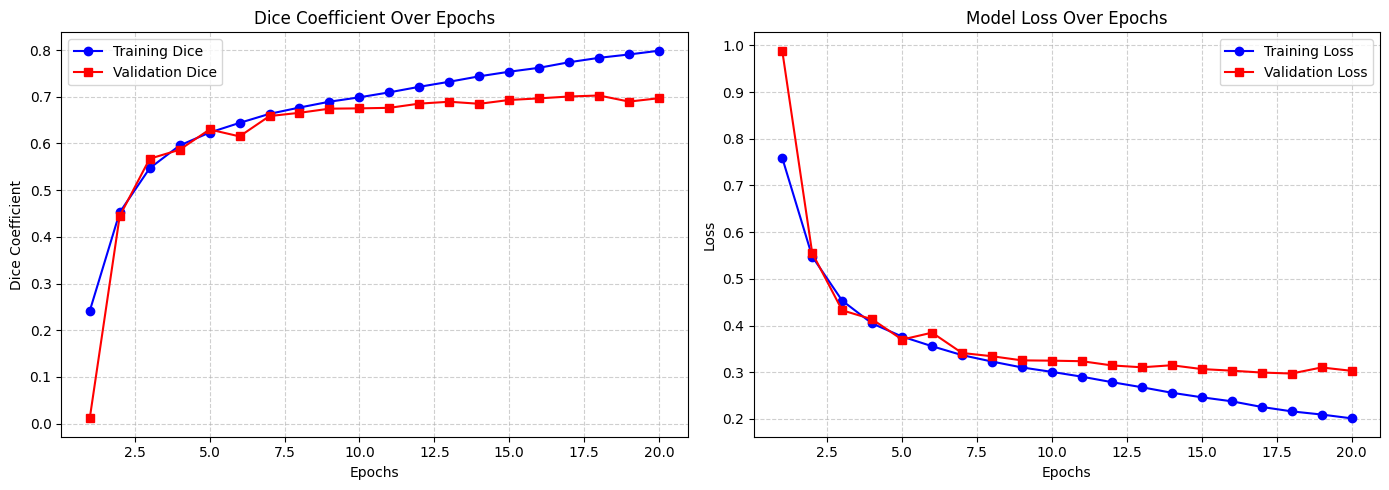

In [ ]:
epochs = range(1, len(history.history['dice_coefficient']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['dice_coefficient'], 'b-o', label='Training Dice')
plt.plot(epochs, history.history['val_dice_coefficient'], 'r-s', label='Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b-o', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r-s', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
test_images = []
for img in test_image_paths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = image / 255.0
    test_images.append(image)

In [ ]:
X_test = np.array(test_images, dtype=np.float32)

2025-07-16 22:25:30.233510: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-07-16 22:25:30.256721: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.023363815s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step

E0000 00:00:1752704779.307078     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752704779.545484     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


35/35 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step 


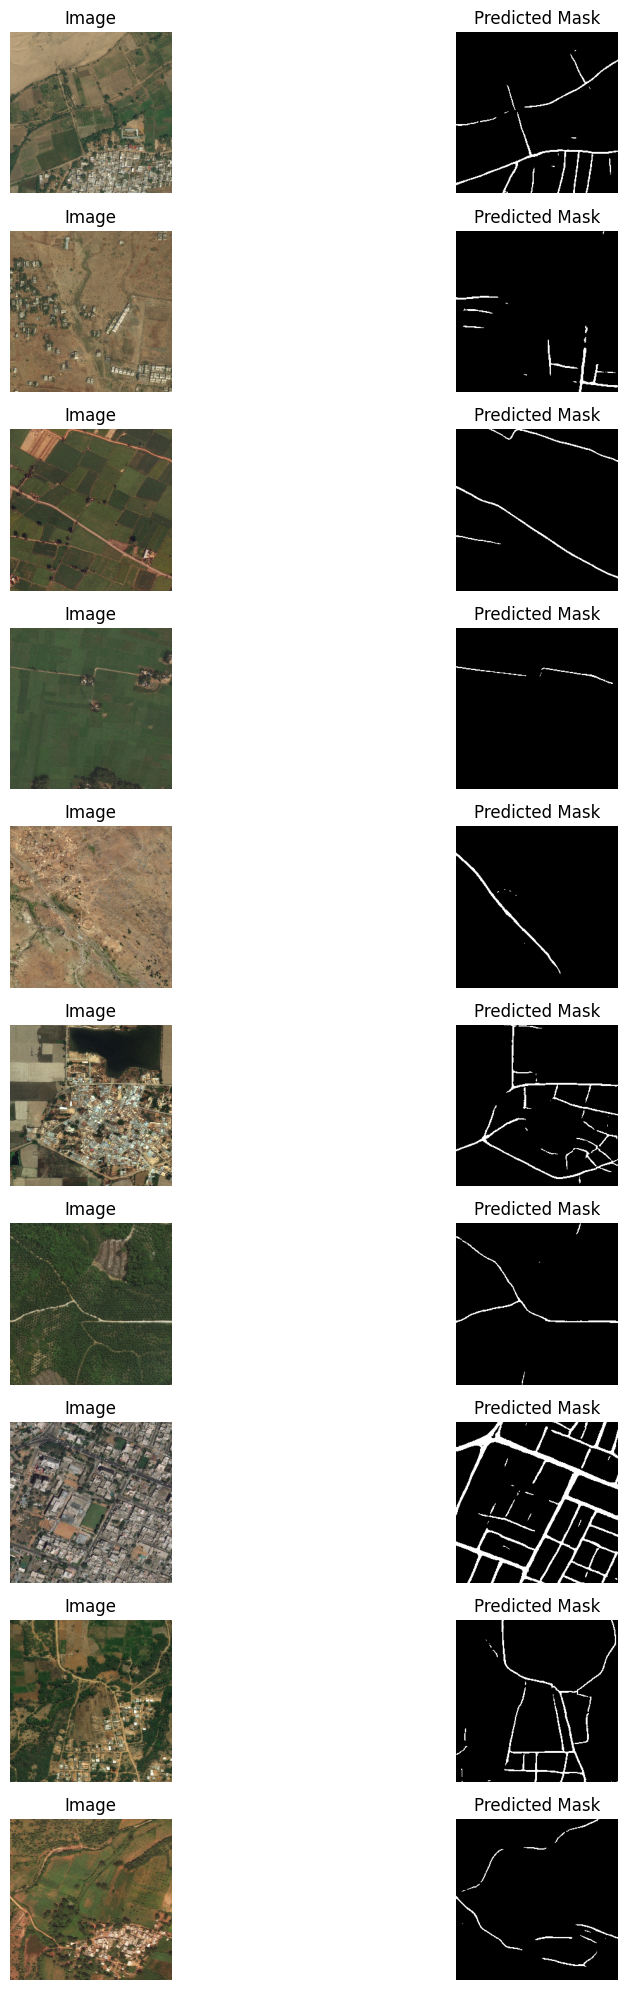

In [ ]:
y_pred = model.predict(X_test)

y_pred_thresh = (y_pred > 0.5).astype(np.uint8)

num_samples = 10

plt.figure(figsize=(12, num_samples * 2))

for i in range(num_samples):
    plt.subplot(num_samples, 2, i * 2 + 1)
    plt.imshow(X_test[i])
    plt.title("Image")
    plt.axis("off")

    plt.subplot(num_samples, 2, i * 2 + 2)
    plt.imshow(y_pred_thresh[i], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()